### Step 1: Load packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
%matplotlib inline
from google.cloud import bigquery
from google.cloud import bigquery_storage
import datetime as dt
from datetime import date, timedelta
import re
from math import ceil
import pingouin as pg
import warnings
warnings.filterwarnings(action = 'ignore') # Suppresses pandas warnings
from IPython.display import display
from tqdm.notebook import tqdm_notebook # Displays progress bars when querying data from BQ
from run_sql_queries import run_query_func

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


### Step 2: Define some input parameters to query the relevant test data

In [2]:
# General inputs
query_path = 'G:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_automation\sql_queries\data_extraction_queries_automated_script.sql' # This is the path to the BQ script that pulls test data
df_raw_data_tbl_name = 'ab_test_individual_orders_cleaned_switchback_tests' # This is the table that contains the cleaned data of switchback tests
alpha_lvl = 0.05 # Set the alpha level below which p-values are statistically significant
p_val_tbl_id = 'dh-logistics-product-ops.pricing.p_vals_switchback_tests' # The table containing the p-values of metrics. This table will be uploaded to BQ at the end of the script
# Define the list of KPIs
col_list = [
    'actual_df_paid_by_customer', 'gfv_local', 'gmv_local', 'commission_local', 'joker_vendor_fee_local', # Customer KPIs (1)
    'sof_local', 'service_fee_local', 'revenue_local', 'delivery_costs_local', 'gross_profit_local', # Customer KPIs (2)
    'dps_mean_delay', 'delivery_distance_m', 'actual_DT' # Logistics KPIs
]

params = [
    {'exp_name': 'TH_20220721_R_F0_O_Switchback_AA_Test_Trang', 'exp_start': dt.date(2022, 7, 21), 'exp_end': dt.date(2022, 8, 17)},
    {'exp_name': 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', 'exp_start': dt.date(2022, 7, 22), 'exp_end': dt.date(2022, 8, 18)},
]

### Step 3.1: Retrieve the switchback test configurations

In [3]:
client = bigquery.Client(project = 'logistics-data-staging-flat') # Instantiate a BQ client and define the project
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client

# The switchback_test_configs_bq table gets updated every hour via a scheduled query
sb_test_configs = client.query("""SELECT * FROM `dh-logistics-product-ops.pricing.switchback_test_configs_bq`""")\
    .result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/2 [00:00<?, ?rows/s]

### Step 3.2: Extract the scheme IDs from between the curly brackets

In [4]:
# Apply the extraction function on the "scheme_id_on" and "scheme_id_off" columns
sb_test_configs['scheme_id_on'] = sb_test_configs['scheme_id_on'].apply(lambda x: re.findall('\{(.*?)\}', x)[0])
sb_test_configs['scheme_id_off'] = sb_test_configs['scheme_id_off'].apply(lambda x: re.findall('\{(.*?)\}', x)[0])


### Step 3.3: Create a list of dicts storing the config info of the switchback tests

In [5]:
# Declare an empty dict that will be contain the details of a particular switchback test in each for loop iteration
# The keys of the dict are the column names of sb_test_configs
test_config_dict = {}
keys = list(sb_test_configs.columns)

# Declare an empty list that will contain all the dicts storing the test config information
test_config_lod = []

# Populate the list of dicts (lod) with the test configuration info
for i in range(0, len(sb_test_configs.index)): # Enumerate over the number of tests
    for key in keys: # Populate an intermediary dict with the config info of the test belonging to the current iteration
        test_config_dict[key] = sb_test_configs[key][i]
    test_config_lod.append(test_config_dict) # Append the intermediary dict to the list of dicts
    test_config_dict = {} # Empty the dict so that it can be populated again

### Step 3.4: Amend the structure of the list of dicts so that "zone" and "scheme" columns contain lists instead of strings

In [6]:
for test in range(0, len(test_config_lod)): # Iterate over the test dicts
    for key in ['zone_name_vendor_excl', 'zone_name_customer_excl', 'scheme_id_on', 'scheme_id_off']: # Iterate over these keys specifically to change their contents to a list
        if test_config_lod[test][key] == None: # If the value of the key is None, change it to an empty list
            test_config_lod[test][key] = []
        else: 
            test_config_lod[test][key] = test_config_lod[test][key].split(', ') # Split the components of the string into list elements
        
        if 'scheme_id' in key: # If the key being accessed contains the word "scheme_id", change the components of the list to integers using list comprehension
            test_config_lod[test][key] = [int(sch) for sch in test_config_lod[test][key]]
        else:
            pass

## <center>END OF INPUT SECTION. NO NEED TO ADJUST ANY CODE FROM HERE ONWARDS</center> ##

### Step 4: Run the queries that pull the data of Switchback tests

In [5]:
run_query_func(query_path)

g:\My Drive\APAC\Autopricing\Switchback Testing\Switchback_AA_Tests\venv_switchback_aa_tests\lib\site-packages\google\auth\_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


The SQL script was executed successfully at 2022-08-25 14:58:15.277884 



### Step 5.1: Get the curated data from the resulting table

In [7]:
df_raw_data = client.query("""SELECT * FROM `dh-logistics-product-ops.pricing.{}`"""\
    .format(df_raw_data_tbl_name))\
    .result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/296226 [00:00<?, ?rows/s]

### Step 5.2: Change the data types of columns in the dataset

In [8]:
# Define the start of the data frame where the data types of columns need to be changed 
col_start = np.where(df_raw_data.columns == 'exchange_rate')[0][0]

# Change data types --> df[df.cols = specific cols].apply(pd.to_numeric)
df_raw_data[df_raw_data.columns[col_start:]] = df_raw_data[df_raw_data.columns[col_start:]].apply(pd.to_numeric, errors = 'ignore')

### Step 6: Define a function that changes the font color based on the p-value

In [9]:
# Define a function that changes the font color based on the p-value
def color_sig_green(val):
    """
    Takes a scalar and returns a string with the css property 'color: green' for statistically significant values, red otherwise
    """
    if pd.isna(val) == False:
        if val <= alpha_lvl:
            color = 'lime'
        else:
            color = 'red'
    else:
        color = 'white'
    return 'color: %s' % color

### Step 8:  Analyze if using smaller time intervals produces insignificant deltas between the variation and control

#### Step 8.1: Create a function that extracts the clean data of one test

In [10]:
# Create a function that extracts the clean data of one test
def df_clean_func(df, test_name):
    """
    A function that cleans the data by filtering for the relevant orders based on the test configurations in this G-sheet
    https://docs.google.com/spreadsheets/d/1JeHPeEFUhDaatvCJqqWBgLxRbe_7kLQkObj-lGEX5X0/edit#gid=0
    """
    pos = [iter['test_name'] for iter in test_config_lod].index(test_name) # Get the index of the test's data in test_config_lod
    
    df_temp = df[
        (df['target_group'] != 'Non_TG') &
        (df['test_name'] == test_config_lod[pos]['test_name']) &
        (~ df['zone_name_vendor'].isin(test_config_lod[pos]['zone_name_vendor_excl'])) &
        (~ df['zone_name_customer'].isin(test_config_lod[pos]['zone_name_customer_excl'])) &
        ((df['scheme_id'].isin(test_config_lod[pos]['scheme_id_on'])) | (df['scheme_id'].isin(test_config_lod[pos]['scheme_id_off']))) &
        (df['order_placed_at_local'].dt.date.between(test_config_lod[pos]['test_start'], test_config_lod[pos]['test_end']))
    ] # Filter out Non_TG orders because they will contain irrelevant price schemes

    # We will add a supplementary column to "df_temp" in the for loop below, so we need to create a function with the conditions
    on_off_conditions = [
        (df_temp['scheme_id'].isin(test_config_lod[pos]['scheme_id_on'])),
        (df_temp['scheme_id'].isin(test_config_lod[pos]['scheme_id_off']))
    ]

    # Add a supplementary column to indicate if the order belonged to an 'On' or 'Off' day
    df_temp['on_or_off_day'] = np.select(on_off_conditions, ['On', 'Off'])

    return df_temp

#### Step 8.2: Create a mapping data frame that has the 'On'/'Off' flag for a user-specified time interval

In [11]:
def hr_interval_func_random(sb_interval):
    bins = int(24 / sb_interval) # The number of bins by which we will divide the range from 0 to 24. A 2-hour switchback interval will have 12 bin --> [0, 2), [2, 4), [4, 6), ... [22, 24)
    if sb_interval >= 1:
        end_of_range = 25
    elif sb_interval == 0.5:
        end_of_range = 24.5
    elif sb_interval == 0.25:
        end_of_range = 24.25
    df_mapping = pd.DataFrame(data = {
            'hr_interval': list(pd.cut(np.arange(0, end_of_range, sb_interval), bins = bins, right = False)) # The bins should be closed from the left
        }
    )

    # Drop duplicates
    df_mapping.drop_duplicates(inplace = True)

    unique_intervals = df_mapping['hr_interval'].unique()
    on_off_list = ['On', 'Off'] * ceil(len(unique_intervals) / 2) # Create the full list that the rng.choice would choose from

    rng = np.random.default_rng()
    df_mapping['treatment_status_by_time'] = rng.choice(on_off_list, replace = False, axis = 0, size = len(df_mapping))
    return df_mapping

In [12]:
def hr_interval_date_func_random(test_start, test_length, sb_interval):
    m = []
    date_iter = test_start # Start date of the test in datetime format
    for i in range(0, test_length): # The length of a test in days
        y = hr_interval_func_random(sb_interval) # The switchback window size
        y['sim_run'] = i + 1
        y['order_created_date_local'] = date_iter
        date_iter = date_iter + timedelta(days = 1)
        m.append(y)

    m = pd.concat(m)
    m.reset_index(inplace = True, drop = True)
    return m

In [ ]:
def day_interval_date_func_random(test_start, test_length): # np.arange has hard-coded 25 and 24 because this function is intended for randomizing the daily assignment of treatment
    rng = np.random.default_rng()
    on_off_list = ['On', 'Off'] * ceil(test_length / 2) # Create the full list that the rng.choice would choose from
    df_mapping = pd.DataFrame(
        data = {
            'hr_interval': list(pd.cut(np.arange(0, 25, 24), bins = 1, right = False))[0] * test_length, # The bins should be closed from the left
            'sim_run': np.arange(1, test_length + 1, 1),
            'order_created_date_local': pd.date_range(start = start_date, periods = 28).date.tolist(),
        }
    )
    df_mapping['treatment_status_by_time'] = rng.choice(on_off_list, replace = False, axis = 0, size = test_length)
    return df_mapping

In [13]:
def hr_interval_func_deterministic(sb_interval):
    bins = int(24 / sb_interval) # The number of bins by which we will divide the range from 0 to 24. A 2-hour switchback interval will have 12 bin --> [0, 2), [2, 4), [4, 6), ... [22, 24)
    if sb_interval >= 1:
        end_of_range = 25
    elif sb_interval == 0.5:
        end_of_range = 24.5
    elif sb_interval == 0.25:
        end_of_range = 24.25
    df_mapping = pd.DataFrame(data = {
            'hr_interval': list(pd.cut(np.arange(0, end_of_range, sb_interval), bins = bins, right = False)) # The bins should be closed from the left
        }
    )

    unique_intervals = df_mapping['hr_interval'].unique()
    tp = list(zip(unique_intervals, ['On', 'Off'] * ceil(len(unique_intervals) / 2)))

    df_mapping['treatment_status_by_time'] = df_mapping['hr_interval'].map(dict(tp))
    return df_mapping.drop_duplicates()

# Create a function that returns the right hr_interval from df_mapping for any given number
def check_right_interval(num, col):
    for i in col:
        if num in i:
            return i
        else:
            pass

#### Step 8.3: Create a function that computes the per order metrics, total metrics, and p-values based on the newly defined 'On'/'Off' granularity

#### MWU test

In [14]:
def df_calc_func(data, test_name, test_start, test_end, sb_interval_hr, sb_groupby_col, rand_determ_assign):
    """
    This function computes the per order metrics, total metrics, and p-values based on a newly defined 'On'/'Off' flag
    """
    # Get the data frame on which you will operate
    df_play = df_clean_func(df = data, test_name = test_name)
    
    # Create a new column with the located created_date of the order 
    df_play['order_created_date_local'] = df_play['order_placed_at_local'].dt.date

    # Filter for the data between test_start and test_end
    df_play = df_play[df_play['order_created_date_local'].between(test_start, test_end)]

    # Create the mapping data frame that has the 'On'/'Off' flag for each time interval
    df_mapping = hr_interval_func_deterministic(sb_interval_hr) if rand_determ_assign == 'determ' else day_interval_date_func_random(test_start = test_start, test_length = (test_end - test_start).days + 1)

    # Get the hour from the "order_placed_at_local" column
    df_play['hr_of_day'] = round(df_play['order_placed_at_local'].dt.hour + df_play['order_placed_at_local'].dt.minute / 60 + df_play['order_placed_at_local'].dt.second / 3600, 2)
    
    # Get the right interval using the "check_right_interval" function
    df_play['hr_interval'] = df_play.apply(lambda x: check_right_interval(x['hr_of_day'], df_mapping['hr_interval'].unique()), axis = 1)
    
    # Map the "hr_interval" to the correct treatment_status
    if rand_determ_assign == 'determ':
        df_play = pd.merge(left = df_play, right = df_mapping, how = 'left', on = 'hr_interval')
    else:
        df_play = pd.merge(left = df_play, right = df_mapping, how = 'left', on = ['hr_interval', 'order_created_date_local'])

    # If the test_name == 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', convert the 'On' values of the Canlubang zone to 'Off' and vice-versa
    def treatment_status_switching_func(zone_name, treatment_status_by_time):
        if zone_name == 'Cabuyao':
            pass
        elif zone_name == 'Canlubang' and treatment_status_by_time == 'On':
            treatment_status_by_time = 'Off'
        elif zone_name == 'Canlubang' and treatment_status_by_time == 'Off':
            treatment_status_by_time = 'On'
        return treatment_status_by_time

    if test_name == 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition':
        df_play['treatment_status_by_time'] = df_play\
            .apply(lambda x: treatment_status_switching_func(x['zone_name_customer'], x['treatment_status_by_time']), axis = 1)

    # Calculate the "total" metrics and rename the column label to "df_per_order_metrics"
    df_play_tot = round(df_play.groupby(['test_name', 'on_or_off_day'])[col_list[:-3]].sum(), 2) if sb_groupby_col == 'on_or_off_day' else\
        round(df_play.groupby(['test_name', 'hr_interval', 'treatment_status_by_time'])[col_list[:-3]].sum(), 2)
    df_play_tot['order_count'] = df_play.groupby(['test_name', 'on_or_off_day'])['order_id'].nunique() if sb_groupby_col == 'on_or_off_day' else\
        df_play.groupby(['test_name', 'hr_interval', 'treatment_status_by_time'])['order_id'].nunique()
    df_play_tot = df_play_tot.rename_axis(['df_tot_metrics'], axis = 1)
    
    # Calculate the "total" metrics and rename the column label to "df_per_order_metrics"
    df_play_per_order_cust_kpis = df_play_tot.copy()

    for iter_col in df_play_per_order_cust_kpis.columns[:-1]:
        df_play_per_order_cust_kpis[iter_col] = round(df_play_per_order_cust_kpis[iter_col] / df_play_per_order_cust_kpis['order_count'], 4)

    df_play_per_order_log_kpis = round(df_play.groupby(['test_name', 'on_or_off_day'])[col_list[-3:]].mean(), 2) if sb_groupby_col == 'on_or_off_day' else\
        round(df_play.groupby(['test_name', 'hr_interval', 'treatment_status_by_time'])[col_list[-3:]].mean(), 2) 
    df_play_per_order = pd.concat([df_play_per_order_cust_kpis, df_play_per_order_log_kpis], axis = 1)
    df_play_per_order = df_play_per_order.rename_axis(['df_per_order_metrics'], axis = 1)
    
    # Add a thousands separator to df_play_tot
    for i in df_play_tot.columns:
        df_play_tot[i] = df_play_tot[i].map('{:,}'.format)

    # Now, we need to calculate the p-values. Create two sub-data frames for the 'On' and 'Off' days
    df_play_on_orders = df_play[df_play['on_or_off_day'] == 'On'] if sb_groupby_col == 'on_or_off_day' else df_play[df_play['treatment_status_by_time'] == 'On']
    df_play_off_orders = df_play[df_play['on_or_off_day'] == 'Off'] if sb_groupby_col == 'on_or_off_day' else df_play[df_play['treatment_status_by_time'] == 'Off']

    df_play_final_pval = []
    pval_dict = {} # Initialize an empty dict that will contain the p-value of each KPI
    for i in col_list:
        pval = round(stats.mannwhitneyu(x = df_play_on_orders[i], y = df_play_off_orders[i], alternative = 'two-sided', nan_policy = 'omit')[1], 4)
        pval_dict[i] = pval

    df_play_final_pval.append(pval_dict)

    # Change the list of dicts "df_final_pval" to a data frame
    df_play_final_pval = pd.DataFrame(df_play_final_pval)\
        .assign(test_name = test_name)\
        .set_index('test_name')
    
    return df_mapping, df_play, df_play_on_orders, df_play_off_orders, df_play_per_order, df_play_tot, df_play_final_pval

#### Step 8.4: Execute the "df_calc_func" function with different sb_intervals

In [69]:
df_pval_mwu_test_sims = []
for i in range(0, 60): # 60 simulations
    df_pval_mwu_test_iter = []

    for test in params:
        df_mapping, df_play, df_play_on_orders, df_play_off_orders, df_play_per_order, df_play_tot, df_play_final_pval = df_calc_func(
            data = df_raw_data, 
            test_name = test['exp_name'], 
            test_start = test['exp_start'], 
            test_end = test['exp_end'],
            sb_interval_hr = 24,
            sb_groupby_col = 'treatment_status_by_time', 
            rand_determ_assign = 'random'
        )
        df_pval_mwu_test_iter.append(df_play_final_pval)
    df_pval_mwu_test_iter = pd.concat(df_pval_mwu_test_iter)
    df_pval_mwu_test_iter['sim_run'] = i + 1
    df_pval_mwu_test_iter.set_index('sim_run', append = True, inplace = True)

    df_pval_mwu_test_sims.append(df_pval_mwu_test_iter)

df_pval_mwu_test_sims = pd.concat(df_pval_mwu_test_sims)
df_pval_mwu_test_sims.head(5).style.format(precision = 4).applymap(color_sig_green)
        

,,actual_df_paid_by_customer,gfv_local,gmv_local,commission_local,joker_vendor_fee_local,sof_local,service_fee_local,revenue_local,delivery_costs_local,gross_profit_local,dps_mean_delay,delivery_distance_m,actual_DT
test_name,sim_run,,,,,,,,,,,,,
TH_20220721_R_F0_O_Switchback_AA_Test_Trang,1,0.0000,0.0000,0.0000,0.0000,0.6877,0.4255,1.0000,0.0000,0.0000,0.0000,0.0000,0.7254,0.0000
PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition,1,0.3143,0.8975,0.0800,0.6757,0.1062,0.4277,1.0000,0.8368,0.0000,0.0053,0.2840,0.3540,0.0001
TH_20220721_R_F0_O_Switchback_AA_Test_Trang,2,0.0000,0.0000,0.0000,0.0000,0.9253,0.8003,1.0000,0.0000,0.0000,0.0000,0.0000,0.2783,0.0000
PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition,2,0.3019,0.9575,0.5145,0.7537,0.9831,0.3161,1.0000,0.9118,0.1916,0.1948,0.0159,0.8908,0.0354
TH_20220721_R_F0_O_Switchback_AA_Test_Trang,3,0.0000,0.6337,0.2081,0.8023,0.4392,0.8787,1.0000,0.0543,0.0000,0.0000,0.0000,0.6191,0.0000


In [71]:
# Calculate the average p-values from the simulations
df_pval_mwu_test_sims.groupby('test_name').mean().style.format(precision = 4).applymap(color_sig_green)

,actual_df_paid_by_customer,gfv_local,gmv_local,commission_local,joker_vendor_fee_local,sof_local,service_fee_local,revenue_local,delivery_costs_local,gross_profit_local,dps_mean_delay,delivery_distance_m,actual_DT
test_name,,,,,,,,,,,,,
PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition,0.3514,0.5100,0.4117,0.5182,0.4293,0.5281,1.0000,0.4839,0.1305,0.2166,0.0948,0.3855,0.2484
TH_20220721_R_F0_O_Switchback_AA_Test_Trang,0.1836,0.1435,0.1439,0.1515,0.5211,0.5041,1.0000,0.1362,0.0288,0.0157,0.0356,0.1753,0.0199


In [100]:
# Calculate the number of times the p-value was below 0.05 (significant) or above 0.05 (insignificant)
num_sims = 60
def num_sims_sig_func(test_name, df):
    df_temp = df[df.index.get_level_values('test_name') == test_name].apply(lambda x: sum(np.where(x <= 0.05, 1, 0))).to_frame(name = 'num_sims_sig_' + test_name)
    df_temp['pct_times_sig'] = round((df_temp.iloc[:, 0] / num_sims) * 100, 2).astype(str) + '%'
    return df_temp

display(num_sims_sig_func(test_name='TH_20220721_R_F0_O_Switchback_AA_Test_Trang', df=df_pval_mwu_test_sims))
display(num_sims_sig_func(test_name='PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', df=df_pval_mwu_test_sims))

,num_sims_sig_TH_20220721_R_F0_O_Switchback_AA_Test_Trang,pct_times_sig
actual_df_paid_by_customer,33,55.0%
gfv_local,40,66.67%
gmv_local,37,61.67%
commission_local,38,63.33%
joker_vendor_fee_local,3,5.0%
sof_local,2,3.33%
service_fee_local,0,0.0%
revenue_local,41,68.33%
delivery_costs_local,56,93.33%
gross_profit_local,55,91.67%


,num_sims_sig_PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition,pct_times_sig
actual_df_paid_by_customer,15,25.0%
gfv_local,5,8.33%
gmv_local,3,5.0%
commission_local,6,10.0%
joker_vendor_fee_local,6,10.0%
sof_local,1,1.67%
service_fee_local,0,0.0%
revenue_local,7,11.67%
delivery_costs_local,36,60.0%
gross_profit_local,30,50.0%


### Step 9: Calculate the significance on time-region units rather than on the order level

#### Welch's t-test

#### Define the function

In [15]:
def sig_calc_time_region_units_func(df, test_name, test_start, test_end, sb_interval_hr, sb_groupby_col, rand_determ_assign): # sb_groupby_col could be 'on_or_off_day' or 'treatment_status_by_time' 
    # Run the df_clean_func to extract the relevant data for the chosen test
    df_t_test = df_clean_func(df, test_name)

    # Create a new column with the located created_date of the order 
    df_t_test['order_created_date_local'] = df_t_test['order_placed_at_local'].dt.date

    # Filter for the data between test_start and test_end
    df_t_test = df_t_test[df_t_test['order_created_date_local'].between(test_start, test_end)]

    # Create the mapping data frame that has the 'On'/'Off' flag for each time interval
    df_mapping = hr_interval_func_deterministic(sb_interval_hr) if rand_determ_assign == 'determ' else hr_interval_date_func_random(test_start = test_start, test_length = (test_end - test_start).days + 1, sb_interval = sb_interval_hr)

    # Get the hour from the "order_placed_at_local" column
    df_t_test['hr_of_day'] = round(df_t_test['order_placed_at_local'].dt.hour + df_t_test['order_placed_at_local'].dt.minute / 60 + df_t_test['order_placed_at_local'].dt.second / 3600, 2)
    
    # Get the right interval using the "check_right_interval" function
    df_t_test['hr_interval'] = df_t_test.apply(lambda x: check_right_interval(x['hr_of_day'], df_mapping['hr_interval'].unique()), axis = 1)

    # Map the "hr_interval" to the correct treatment_status
    if rand_determ_assign == 'determ':
        df_t_test = pd.merge(left = df_t_test, right = df_mapping, how = 'left', on = 'hr_interval')
    else:
        df_t_test = pd.merge(left = df_t_test, right = df_mapping, how = 'left', on = ['hr_interval', 'order_created_date_local'])

    # If the test_name == 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', convert the 'On' values of the Canlubang zone to 'Off' and vice-versa
    def treatment_status_switching_func(zone_name, treatment_status_by_time):
        if zone_name == 'Cabuyao':
            pass
        elif zone_name == 'Canlubang' and treatment_status_by_time == 'On':
            treatment_status_by_time = 'Off'
        elif zone_name == 'Canlubang' and treatment_status_by_time == 'Off':
            treatment_status_by_time = 'On'
        return treatment_status_by_time

    if test_name == 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition':
        df_t_test['treatment_status_by_time'] = df_t_test\
            .apply(lambda x: treatment_status_switching_func(x['zone_name_customer'], x['treatment_status_by_time']), axis = 1)

    # Calculate the mean values per created_date_local date (time-region unit)
    df_agg_units = round(df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'on_or_off_day'])[col_list[:-3]].sum(), 2) if sb_groupby_col == 'on_or_off_day' else\
        round(df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])[col_list[:-3]].sum(), 2)
    
    log_kpis = round(df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'on_or_off_day'])[col_list[-3:]].mean(), 2) if sb_groupby_col == 'on_or_off_day' else\
        round(df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])[col_list[-3:]].mean(), 2) 

    df_agg_units = pd.concat([df_agg_units, log_kpis], axis = 1)
    df_agg_units['order_count'] = df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'on_or_off_day'])['order_id'].nunique() if sb_groupby_col == 'on_or_off_day' else\
        df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])['order_id'].nunique()

    for iter_col in df_agg_units.columns[:-4]:
        df_agg_units[iter_col] = round(df_agg_units[iter_col] / df_agg_units['order_count'], 4)

    # Calculate the p-values using the Welch's t-test
    pval_dict = {}
    df_pval_final_list = []

    for iter_col in df_agg_units.columns:
        on_data_for_t_test = df_agg_units[df_agg_units.index.get_level_values('on_or_off_day') == 'On'][iter_col] if sb_groupby_col == 'on_or_off_day' else\
            df_agg_units[df_agg_units.index.get_level_values('treatment_status_by_time') == 'On'][iter_col]

        off_data_for_t_test = df_agg_units[df_agg_units.index.get_level_values('on_or_off_day') == 'Off'][iter_col] if sb_groupby_col == 'on_or_off_day' else\
            df_agg_units[df_agg_units.index.get_level_values('treatment_status_by_time') == 'Off'][iter_col]
        
        pval_dict[iter_col] = stats.ttest_ind(
            a = on_data_for_t_test,
            b = off_data_for_t_test,
            equal_var = False,
            nan_policy = 'omit',
            alternative = 'two-sided'
        )[1].round(4)
    df_pval_final_list.append(pval_dict)

    # Convert the p-values to a data frame
    df_pval_final_tbl = pd.DataFrame(df_pval_final_list)\
        .assign(test_name = test_name)\
        .set_index('test_name')
    
    return df_t_test, df_agg_units, df_pval_final_tbl, df_pval_final_tbl.style.format(precision = 4).applymap(color_sig_green) # 3 (without styling) and # 4 (with styling)

#### One-off calculation

In [16]:
# Run the function
df_t_test, df_agg_t_test, df_pval_t_test_wout_styling, df_pval_t_test_with_styling = sig_calc_time_region_units_func(
    df = df_raw_data, 
    test_name = 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition',
    test_start = dt.date(2022, 7, 22),
    test_end = dt.date(2022, 8, 18),
    sb_interval_hr = 6,
    sb_groupby_col = 'on_or_off_day',
    rand_determ_assign = 'determ'
)

#### Calculation for all tests

In [16]:
sb_interval_dict = {'12_hr_sb': 12, '6_hr_sb': 6, '4_hr_sb': 4, '2_hr_sb': 2, '1_hr_sb': 1, '0.5_hr_sb': 0.5, '0.25_hr_sb': 0.25} # Exclude the 8-hour window size
def p_vals_for_diff_sb_intervals_func(exp_name, exp_start, exp_end, sb_groupby_col, rand_determ_assign):
    dict_pval_t_test_sims = {}
    df_pval_t_test_sims = []

    for key, value in sb_interval_dict.items():
        df_t_test, df_agg_t_test, df_pval_t_test_wout_styling, df_pval_t_test_with_styling = sig_calc_time_region_units_func(
            df = df_raw_data, 
            test_name = exp_name,
            test_start = exp_start,
            test_end = exp_end,
            sb_interval_hr = value, 
            sb_groupby_col = sb_groupby_col,
            rand_determ_assign = rand_determ_assign
        )
        df_pval_t_test_sims.append(df_pval_t_test_wout_styling)

    df_pval_t_test_sims = pd.concat(df_pval_t_test_sims)
    df_pval_t_test_sims['sb_interval_hr'] = sb_interval_dict.values()
    # df_pval_t_test_sims['sb_interval_hr'] = df_pval_t_test_sims['sb_interval_hr'].astype(str)
    df_pval_t_test_sims.set_index('sb_interval_hr', append = True, inplace = True)
    return df_pval_t_test_sims

In [17]:
df_pval_t_test_sims = []

for i in range(0, 60): # 60 simulations
    df_pval_t_test_iter = []

    for test in params:
        df_pval_t_test_iter.append(
            p_vals_for_diff_sb_intervals_func(
                exp_name = test['exp_name'], 
                exp_start = test['exp_start'],
                exp_end = test['exp_end'], 
                sb_groupby_col = 'treatment_status_by_time', 
                rand_determ_assign = 'random'
            )
        )

    df_pval_t_test_iter = pd.concat(df_pval_t_test_iter)
    df_pval_t_test_iter['sim_run'] = i + 1
    df_pval_t_test_iter.set_index('sim_run', append = True, inplace = True)
    
    # Display the data frame with a formatted style
    df_pval_t_test_sims.append(df_pval_t_test_iter)
    
df_pval_t_test_sims = pd.concat(df_pval_t_test_sims)

In [18]:
# Display the df_pval_t_test_sims data frame in a good format
df_pval_t_test_sims_sorted = df_pval_t_test_sims.groupby(['test_name', 'sb_interval_hr']).mean()
df_pval_t_test_sims_sorted.index = df_pval_t_test_sims_sorted.index.set_levels(df_pval_t_test_sims_sorted.index.levels[1].astype(float), level = 1)
df_pval_t_test_sims_sorted.sort_values(by = ['test_name', 'sb_interval_hr'], axis = 0, ascending = False).style.format('{:,.4f}').applymap(color_sig_green)

In [48]:
# Calculate the number of times the p-value was below 0.05 (significant) or above 0.05 (insignificant)
num_sims = 60
def num_sims_sig_func(test_name, df):
    df_temp = df[(df.index.get_level_values('test_name') == test_name)].groupby('sb_interval_hr').apply(lambda x: x[x <= 0.05].count()).sort_index(ascending = False)
    df_temp.rename_axis('num_sims_sig_' + test_name[0:2], inplace=True, axis=1)
    df_temp = df_temp.applymap(lambda x: str(round((x / num_sims) * 100, 2)) + '%')
    
    return df_temp

display(num_sims_sig_func(test_name='TH_20220721_R_F0_O_Switchback_AA_Test_Trang', df=df_pval_t_test_sims))
display(num_sims_sig_func(test_name='PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', df=df_pval_t_test_sims))

num_sims_sig_TH,actual_df_paid_by_customer,gfv_local,gmv_local,commission_local,joker_vendor_fee_local,sof_local,service_fee_local,revenue_local,delivery_costs_local,gross_profit_local,dps_mean_delay,delivery_distance_m,actual_DT,order_count
sb_interval_hr,,,,,,,,,,,,,,
12.00,5.0%,0.0%,0.0%,0.0%,8.33%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,20.0%
6.00,3.33%,1.67%,1.67%,3.33%,3.33%,5.0%,0.0%,3.33%,1.67%,5.0%,1.67%,5.0%,3.33%,5.0%
4.00,5.0%,1.67%,3.33%,6.67%,1.67%,0.0%,0.0%,10.0%,3.33%,3.33%,5.0%,5.0%,5.0%,6.67%
2.00,3.33%,1.67%,1.67%,1.67%,0.0%,8.33%,0.0%,1.67%,1.67%,1.67%,1.67%,5.0%,0.0%,10.0%
1.00,8.33%,6.67%,3.33%,1.67%,5.0%,8.33%,0.0%,1.67%,1.67%,3.33%,3.33%,3.33%,3.33%,3.33%
0.50,0.0%,8.33%,8.33%,13.33%,3.33%,3.33%,0.0%,11.67%,8.33%,5.0%,3.33%,1.67%,6.67%,1.67%
0.25,5.0%,1.67%,1.67%,5.0%,5.0%,6.67%,0.0%,5.0%,8.33%,3.33%,5.0%,3.33%,8.33%,6.67%


num_sims_sig_PH,actual_df_paid_by_customer,gfv_local,gmv_local,commission_local,joker_vendor_fee_local,sof_local,service_fee_local,revenue_local,delivery_costs_local,gross_profit_local,dps_mean_delay,delivery_distance_m,actual_DT,order_count
sb_interval_hr,,,,,,,,,,,,,,
12.00,1.67%,0.0%,1.67%,5.0%,5.0%,8.33%,0.0%,6.67%,0.0%,1.67%,0.0%,0.0%,0.0%,0.0%
6.00,0.0%,0.0%,1.67%,1.67%,1.67%,1.67%,0.0%,1.67%,1.67%,1.67%,0.0%,1.67%,1.67%,0.0%
4.00,3.33%,0.0%,3.33%,11.67%,1.67%,3.33%,0.0%,10.0%,6.67%,11.67%,5.0%,3.33%,0.0%,0.0%
2.00,3.33%,3.33%,1.67%,3.33%,0.0%,6.67%,0.0%,5.0%,5.0%,3.33%,1.67%,6.67%,1.67%,0.0%
1.00,3.33%,6.67%,6.67%,3.33%,1.67%,5.0%,0.0%,3.33%,1.67%,1.67%,0.0%,0.0%,1.67%,0.0%
0.50,5.0%,8.33%,10.0%,5.0%,3.33%,6.67%,0.0%,5.0%,3.33%,6.67%,1.67%,10.0%,3.33%,0.0%
0.25,3.33%,3.33%,5.0%,1.67%,8.33%,6.67%,0.0%,3.33%,1.67%,3.33%,5.0%,3.33%,3.33%,1.67%


### Step 10: Reverse Power Analysis

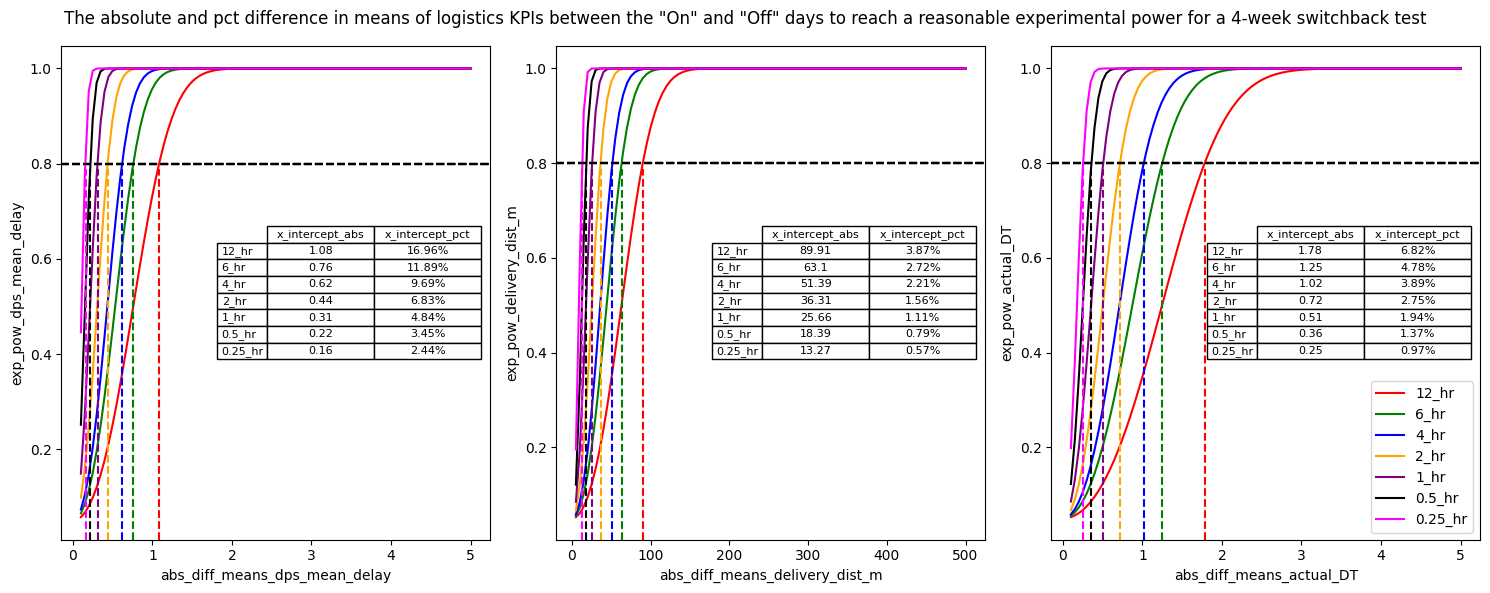

In [18]:
# Sample size
sb_window_size = [12, 6, 4, 2, 1, 0.5, 0.25]
pow_colors = ['red', 'green', 'blue', 'orange', 'purple', 'black', 'fuchsia']
nobs1 = [int((24 / i) * 14) for i in sb_window_size] # 28 days / 2 because we have two samples = 14

# Calculate the standard deviations of the logistics KPIs
df_std_dev_log_kpis = df_agg_t_test[['dps_mean_delay', 'delivery_distance_m', 'actual_DT']].std().round(3).to_frame(name = 'std_dev')

# Calculate the means of logistics KPIs grouped by 'On'/'Off' days
df_means_log_kpis = df_agg_t_test.groupby('on_or_off_day')[['dps_mean_delay', 'delivery_distance_m', 'actual_DT']].mean().round(3).reset_index()

# Create a data frame for the power analysis (assume we need 100 data points to construct the graph)
data_points = 100
df_pow = pd.DataFrame({
    'mean_dps_mean_delay_off_day': [df_means_log_kpis.loc[df_means_log_kpis['on_or_off_day'] == 'Off', 'dps_mean_delay'][0]] * data_points,
    'abs_diff_means_dps_mean_delay': np.linspace(0.1, 5, num = data_points),
    'std_dev_dps_mean_delay': [df_std_dev_log_kpis[df_std_dev_log_kpis.index.get_level_values(0) == 'dps_mean_delay']['std_dev'][0]] * data_points,
    
    'mean_delivery_dist_m_off_day': [df_means_log_kpis.loc[df_means_log_kpis['on_or_off_day'] == 'Off', 'delivery_distance_m'][0]] * data_points,
    'abs_diff_means_delivery_dist_m': np.linspace(5, 500, num = data_points),
    'std_dev_delivery_dist_m': [df_std_dev_log_kpis[df_std_dev_log_kpis.index.get_level_values(0) == 'delivery_distance_m']['std_dev'][0]] * data_points,
    
    'mean_actual_DT_off_day': [df_means_log_kpis.loc[df_means_log_kpis['on_or_off_day'] == 'Off', 'actual_DT'][0]] * data_points,
    'abs_diff_means_actual_DT': np.linspace(0.1, 5, num = data_points),
    'std_dev_actual_DT': [df_std_dev_log_kpis[df_std_dev_log_kpis.index.get_level_values(0) == 'actual_DT']['std_dev'][0]] * data_points,
    }
)

# Create three new columns that have the effect size (difference between means / std deviation)
df_pow = df_pow.assign(
    pct_diff_means_dps_mean_delay = ((df_pow['abs_diff_means_dps_mean_delay'] / df_pow['mean_dps_mean_delay_off_day']) * 100).round(3),
    pct_diff_means_delivery_dist_m = ((df_pow['abs_diff_means_delivery_dist_m'] / df_pow['mean_delivery_dist_m_off_day']) * 100).round(3),
    pct_diff_means_actual_DT = ((df_pow['abs_diff_means_actual_DT'] / df_pow['mean_actual_DT_off_day']) * 100).round(3),
    effect_size_dps_mean_delay = df_pow['abs_diff_means_dps_mean_delay'] / df_pow['std_dev_dps_mean_delay'],
    effect_size_delivery_dist_m = df_pow['abs_diff_means_delivery_dist_m'] / df_pow['std_dev_delivery_dist_m'],
    effect_size_actual_DT = df_pow['abs_diff_means_actual_DT'] / df_pow['std_dev_actual_DT'],
)

# Create the table containing the absolute and % values of the chart's x-axis
df_x_intercept_dps_mean_delay = pd.DataFrame(data = {'x_intercept_abs': None, 'x_intercept_pct': None}, index = [str(i) + '_hr' for i in sb_window_size])
df_x_intercept_delivery_dist_m = pd.DataFrame(data = {'x_intercept_abs': None, 'x_intercept_pct': None}, index = [str(i) + '_hr' for i in sb_window_size])
df_x_intercept_actual_DT = pd.DataFrame(data = {'x_intercept_abs': None, 'x_intercept_pct': None}, index = [str(i) + '_hr' for i in sb_window_size])

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,6))
for iter, i in enumerate(nobs1):
    # Calculate the experiment's power
    power_analysis = TTestIndPower()
    df_pow[['exp_pow_dps_mean_delay', 'exp_pow_delivery_dist_m', 'exp_pow_actual_DT']] = df_pow[['effect_size_dps_mean_delay', 'effect_size_delivery_dist_m', 'effect_size_actual_DT']]\
        .apply(lambda x: power_analysis.power(effect_size = x, alpha = 0.05, nobs1 = i, ratio = 1, alternative = 'two-sided'))

    # Calculate the x-intercepts
    x_intercept_dps_mean_delay_abs = np.interp(0.8, df_pow['exp_pow_dps_mean_delay'], df_pow['abs_diff_means_dps_mean_delay']).round(2)
    x_intercept_dps_mean_delay_pct = str(np.interp(0.8, df_pow['exp_pow_dps_mean_delay'], df_pow['pct_diff_means_dps_mean_delay']).round(2)) + '%'

    x_intercept_delivery_dist_m_abs = np.interp(0.8, df_pow['exp_pow_delivery_dist_m'], df_pow['abs_diff_means_delivery_dist_m']).round(2)
    x_intercept_delivery_dist_m_pct = str(np.interp(0.8, df_pow['exp_pow_delivery_dist_m'], df_pow['pct_diff_means_delivery_dist_m']).round(2)) + '%'

    x_intercept_actual_DT_abs = np.interp(0.8, df_pow['exp_pow_actual_DT'], df_pow['abs_diff_means_actual_DT']).round(2)
    x_intercept_actual_DT_pct = str(np.interp(0.8, df_pow['exp_pow_actual_DT'], df_pow['pct_diff_means_actual_DT']).round(2)) + '%'

    # Assign the values to the dataframes
    df_x_intercept_dps_mean_delay.iloc[iter, 0] = x_intercept_dps_mean_delay_abs
    df_x_intercept_dps_mean_delay.iloc[iter, 1] = x_intercept_dps_mean_delay_pct
    
    df_x_intercept_delivery_dist_m.iloc[iter, 0] = x_intercept_delivery_dist_m_abs
    df_x_intercept_delivery_dist_m.iloc[iter, 1] = x_intercept_delivery_dist_m_pct
    
    df_x_intercept_actual_DT.iloc[iter, 0] = x_intercept_actual_DT_abs
    df_x_intercept_actual_DT.iloc[iter, 1] = x_intercept_actual_DT_pct

    # Plot the graphs
    axes[0].plot(df_pow['abs_diff_means_dps_mean_delay'], df_pow['exp_pow_dps_mean_delay'], color = pow_colors[iter], label = str(sb_window_size[iter]) + '_hr')
    # axes[0].legend(str(i) + '_hr')
    axes[0].axhline(0.8, color = 'black', linestyle = '--')
    axes[0].axvline(x_intercept_dps_mean_delay_abs, ymin=0, ymax=0.75, color = pow_colors[iter], linestyle = '--')
    # % and absolute
    # axes[0].text(x = x_intercept_dps_mean_delay_abs + 0.05, y = 0.2, s = str(x_intercept_dps_mean_delay_abs.round(1)) + ' | ' + x_intercept_dps_mean_delay_pct.round(1).astype(str) + '%', fontweight = 'bold')
    # % only
    # axes[0].text(x = x_intercept_dps_mean_delay_abs + 0.05, y = 0.2, s = x_intercept_dps_mean_delay_pct.round(1).astype(str) + '%', fontweight = 'bold')
    axes[0].set_xlabel('abs_diff_means_dps_mean_delay')
    axes[0].set_ylabel('exp_pow_dps_mean_delay')

    axes[1].plot(df_pow['abs_diff_means_delivery_dist_m'], df_pow['exp_pow_delivery_dist_m'], color = pow_colors[iter], label = str(sb_window_size[iter]) + '_hr')
    # axes[1].legend(str(i) + '_hr')
    axes[1].axhline(0.8, color = 'black', linestyle = '--')
    axes[1].axvline(np.interp(0.8, df_pow['exp_pow_delivery_dist_m'], df_pow['abs_diff_means_delivery_dist_m']), ymin=0, ymax=0.75, color = pow_colors[iter], linestyle = '--')
    # % and absolute
    # axes[1].text(x = x_intercept_delivery_dist_m_abs + 0.5, y = 0.2, s = str(x_intercept_delivery_dist_m_abs.round(1)) + ' | ' + x_intercept_delivery_dist_m_pct.round(1).astype(str) + '%', fontweight = 'bold')
    # % only
    # axes[1].text(x = x_intercept_delivery_dist_m_abs + 0.5, y = 0.2, s = x_intercept_delivery_dist_m_pct.round(1).astype(str) + '%', fontweight = 'bold')
    axes[1].set_xlabel('abs_diff_means_delivery_dist_m')
    axes[1].set_ylabel('exp_pow_delivery_dist_m')

    axes[2].plot(df_pow['abs_diff_means_actual_DT'], df_pow['exp_pow_actual_DT'], color = pow_colors[iter], label = str(sb_window_size[iter]) + '_hr')
    # axes[2].legend(pow_colors, [str(i) + '_hr' for i in sb_window_size])
    axes[2].axhline(0.8, color = 'black', linestyle = '--')
    axes[2].axvline(np.interp(0.8, df_pow['exp_pow_actual_DT'], df_pow['abs_diff_means_actual_DT']), ymin=0, ymax=0.75, color = pow_colors[iter], linestyle = '--')
    # % and absolute
    # axes[2].text(x = x_intercept_actual_DT_abs + 0.05, y = 0.2, s = str(x_intercept_actual_DT_pct.round(1)) + ' | ' + x_intercept_actual_DT_pct.round(1).astype(str) + '%', fontweight = 'bold')
    # % only
    # axes[2].text(x = x_intercept_actual_DT_abs + 0.05, y = 0.2, s = x_intercept_actual_DT_pct.round(1).astype(str) + '%', fontweight = 'bold')
    axes[2].set_xlabel('abs_diff_means_actual_DT')
    axes[2].set_ylabel('exp_pow_actual_DT')
    plt.suptitle('The absolute and pct difference in means of logistics KPIs between the "On" and "Off" days to reach a reasonable experimental power for a 4-week switchback test')
    plt.tight_layout()
    plt.legend()
df_pow.head(10)

axes[0].table(
        cellText = df_x_intercept_dps_mean_delay.values.tolist(),
        colWidths = [0.25]*3,
        rowLabels = df_x_intercept_dps_mean_delay.index.values,
        colLabels = df_x_intercept_dps_mean_delay.columns,
        loc='center right',
        cellLoc = 'center'   
)  
axes[1].table(
        cellText = df_x_intercept_delivery_dist_m.values.tolist(),
        colWidths = [0.25]*3,
        rowLabels = df_x_intercept_delivery_dist_m.index.values,
        colLabels = df_x_intercept_delivery_dist_m.columns,
        loc='center right',
        cellLoc = 'center'   
)
axes[2].table(
        cellText = df_x_intercept_actual_DT.values.tolist(),
        colWidths = [0.25]*3,
        rowLabels = df_x_intercept_actual_DT.index.values,
        colLabels = df_x_intercept_actual_DT.columns,
        loc='center right',
        cellLoc = 'center'   
)

### Step 11: Margin of error calculations

In [17]:
def std_error_df_generator_func(df, test_name, test_start, test_end, sb_interval_hr, rand_determ_assign): # sb_groupby_col could be 'on_or_off_day' or 'treatment_status_by_time' 
    # Run the df_clean_func to extract the relevant data for the chosen test
    df_t_test = df_clean_func(df, test_name)

    # Create a new column with the located created_date of the order 
    df_t_test['order_created_date_local'] = df_t_test['order_placed_at_local'].dt.date

    # Filter for the data between test_start and test_end
    df_t_test = df_t_test[df_t_test['order_created_date_local'].between(test_start, test_end)]

    # Create the mapping data frame that has the 'On'/'Off' flag for each time interval
    df_mapping = hr_interval_func_deterministic(sb_interval_hr) if rand_determ_assign == 'determ' else hr_interval_date_func_random(test_start = test_start, test_length = (test_end - test_start).days + 1, sb_interval = sb_interval_hr)

    # Get the hour from the "order_placed_at_local" column
    df_t_test['hr_of_day'] = round(df_t_test['order_placed_at_local'].dt.hour + df_t_test['order_placed_at_local'].dt.minute / 60 + df_t_test['order_placed_at_local'].dt.second / 3600, 2)
    
    # Get the right interval using the "check_right_interval" function
    df_t_test['hr_interval'] = df_t_test.apply(lambda x: check_right_interval(x['hr_of_day'], df_mapping['hr_interval'].unique()), axis = 1)

    # Map the "hr_interval" to the correct treatment_status
    if rand_determ_assign == 'determ':
        df_t_test = pd.merge(left = df_t_test, right = df_mapping, how = 'left', on = 'hr_interval')
    else:
        df_t_test = pd.merge(left = df_t_test, right = df_mapping, how = 'left', on = ['hr_interval', 'order_created_date_local'])

    # If the test_name == 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', convert the 'On' values of the Canlubang zone to 'Off' and vice-versa
    def treatment_status_switching_func(zone_name, treatment_status_by_time):
        if zone_name == 'Cabuyao':
            pass
        elif zone_name == 'Canlubang' and treatment_status_by_time == 'On':
            treatment_status_by_time = 'Off'
        elif zone_name == 'Canlubang' and treatment_status_by_time == 'Off':
            treatment_status_by_time = 'On'
        return treatment_status_by_time

    if test_name == 'PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition':
        df_t_test['treatment_status_by_time'] = df_t_test\
            .apply(lambda x: treatment_status_switching_func(x['zone_name_customer'], x['treatment_status_by_time']), axis = 1)

        # Calculate the mean values per created_date_local date (time-region unit)
    df_agg_units = round(df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])[col_list[:-3]].sum(), 2)
    
    log_kpis = round(df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])[col_list[-3:]].mean(), 2) 

    df_agg_units = pd.concat([df_agg_units, log_kpis], axis = 1)
    df_agg_units['order_count'] = df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])['order_id'].nunique()

    for iter_col in df_agg_units.columns[:-4]:
        df_agg_units[iter_col] = round(df_agg_units[iter_col] / df_agg_units['order_count'], 4)

    return df_agg_units

In [49]:
df_agg_units_std_error = std_error_df_generator_func(
    df = df_raw_data, 
    test_name = 'TH_20220721_R_F0_O_Switchback_AA_Test_Trang',
    test_start = dt.date(2022, 7, 21),
    test_end = dt.date(2022, 8, 17),
    sb_interval_hr = 6,
    rand_determ_assign = 'random'
)

In [18]:
std_error_sb_interval_dict = {'24_hr_sb': 24, '12_hr_sb': 12, '6_hr_sb': 6, '4_hr_sb': 4, '2_hr_sb': 2, '1_hr_sb': 1, '0.5_hr_sb': 0.5, '0.25_hr_sb': 0.25} # Exclude the 8-hour window size
def std_error_for_diff_sb_intervals_func(exp_name, exp_start, exp_end):
    df_std_error = [] # Margin of error

    for key, value in std_error_sb_interval_dict.items():
        df_agg_units_std_error = std_error_df_generator_func(
            df = df_raw_data, 
            test_name = exp_name,
            test_start = exp_start,
            test_end = exp_end,
            sb_interval_hr = value,
            rand_determ_assign = 'random'
        )
        q1 = df_agg_units_std_error.quantile(q=.25)
        q3 = df_agg_units_std_error.quantile(q=.75)
        iqr = df_agg_units_std_error.apply(stats.iqr)

        df_agg_units_std_error = df_agg_units_std_error[~((df_agg_units_std_error < (q1 - 1.5 * iqr)) | (df_agg_units_std_error > (q3 + 1.5 * iqr))).any(axis=1)] # Remove outliers
        
        df_agg_treatment_std_error = df_agg_units_std_error.groupby('treatment_status_by_time').std().round(3).applymap(lambda x: x / np.sqrt(24 / value))
        df_agg_treatment_std_error['std_dev_sb_interval'] = 'std_dev_' + str(value) + '_hr'
        df_agg_treatment_std_error['sb_interval_for_sorting'] = value
        df_agg_treatment_std_error.set_index('std_dev_sb_interval', inplace = True, append = True)
        df_agg_treatment_std_error = df_agg_treatment_std_error.reorder_levels(['std_dev_sb_interval', 'treatment_status_by_time'], axis = 0)
        df_std_error.append(df_agg_treatment_std_error)

    df_std_error = pd.concat(df_std_error)
    df_std_error['test_name'] = exp_name
    df_std_error.set_index('test_name', inplace = True, append = True)
    df_std_error = df_std_error.reorder_levels(['test_name', 'std_dev_sb_interval', 'treatment_status_by_time'], axis = 0)
    return df_std_error

In [67]:
df_std_error_sims = []

for i in range(0, 30): # 30 simulations
    df_std_error_iter = []
    for test in params:
        df_std_error_iter.append(std_error_for_diff_sb_intervals_func(exp_name = test['exp_name'], exp_start = test['exp_start'], exp_end = test['exp_end']))

    df_std_error_iter = pd.concat(df_std_error_iter)
    df_std_error_iter['sim_run'] = i + 1
    df_std_error_iter.set_index('sim_run', append = True, inplace = True)

    df_std_error_sims.append(df_std_error_iter)

# Display the data frame with a formatted style
df_std_error_sims = pd.concat(df_std_error_sims)

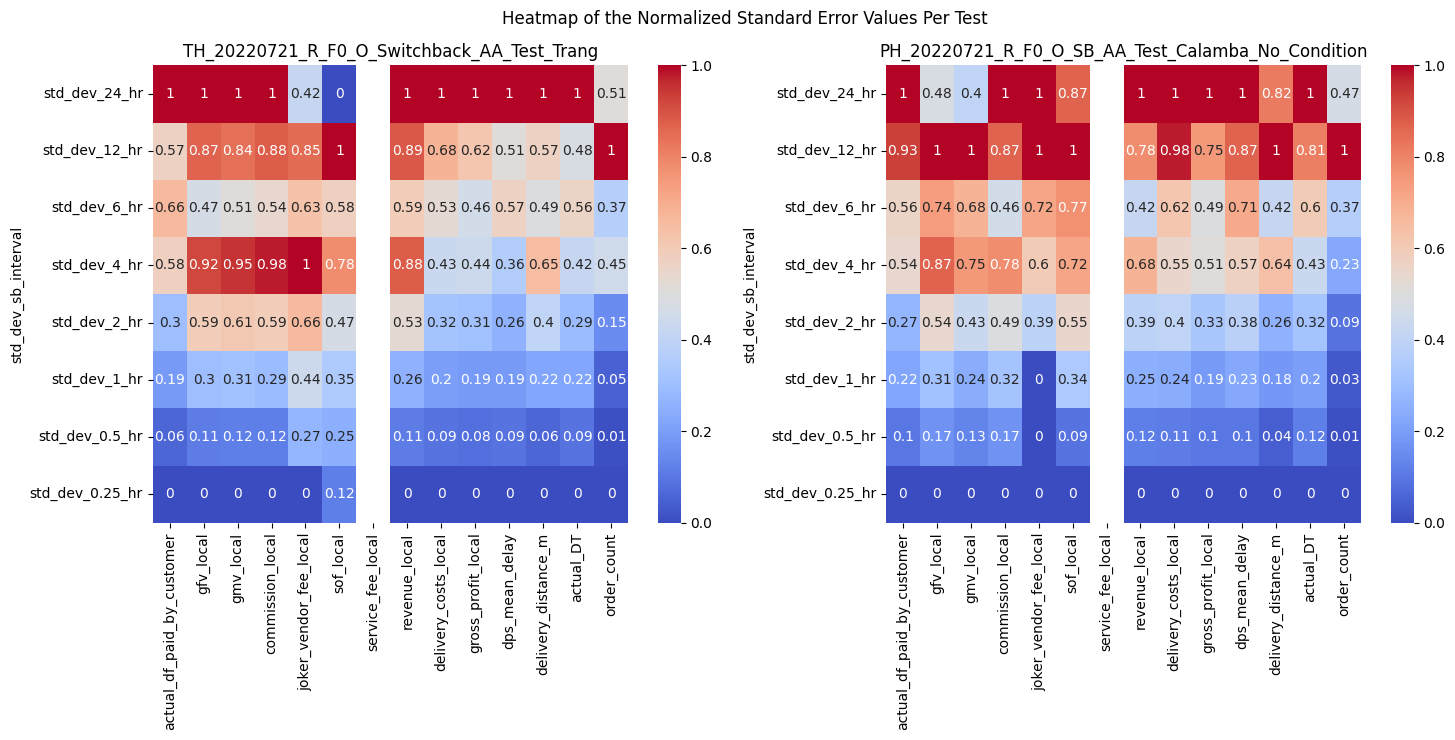

In [68]:
# Prepare a matrix for the heatmap plot
status = 'Off'
df_std_error_heatmap = df_std_error_sims[df_std_error_sims.index.get_level_values('treatment_status_by_time') == status].groupby(['test_name', 'std_dev_sb_interval', 'treatment_status_by_time']).mean()\
    .sort_values(by = ['test_name', 'sb_interval_for_sorting'], axis = 0, ascending = False).droplevel(level = 2, axis = 0).drop('sb_interval_for_sorting', axis = 1)

# Draw a heatmap out of the standard errors
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7.5))
sns.heatmap(
    df_std_error_heatmap.xs('TH_20220721_R_F0_O_Switchback_AA_Test_Trang', axis = 0, level = 0).apply(lambda x: round((x - min(x)) / (max(x) - min(x)), 2)), 
    cmap = 'coolwarm', annot = True, ax = ax[0])
ax[0].set_title('TH_20220721_R_F0_O_Switchback_AA_Test_Trang')
sns.heatmap(
    df_std_error_heatmap.xs('PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', axis = 0, level = 0).apply(lambda x: round((x - min(x)) / (max(x) - min(x)), 2)),
    cmap = 'coolwarm', annot = True, ax = ax[1])
ax[1].set_title('PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition')
plt.suptitle('Heatmap of the Normalized Standard Error Values Per Test')
plt.tight_layout()

### Step 12: Equal split check when randomizing

In [24]:
def split_check_func(rand_determ_assign):
    sb_interval_dict = {'12_hr_sb': 12, '6_hr_sb': 6, '4_hr_sb': 4, '2_hr_sb': 2, '1_hr_sb': 1, '0.5_hr_sb': 0.5, '0.25_hr_sb': 0.25} # Exclude the 8-hour window size
    df_split_check = []

    for test in params:
        for key, value in sb_interval_dict.items():
            df_t_test_split, df_agg_t_test_split, df_pval_t_test_wout_styling_split, df_pval_t_test_with_styling_split = sig_calc_time_region_units_func(
                df = df_raw_data, 
                test_name = test['exp_name'],
                test_start = test['exp_start'],
                test_end = test['exp_end'],
                sb_interval_hr = value,
                sb_groupby_col = 'treatment_status_by_time',
                rand_determ_assign = rand_determ_assign
            )
            df_split = df_agg_t_test_split.groupby('treatment_status_by_time')['actual_df_paid_by_customer'].count().to_frame(name = 'number_of_instances_all_other_kpis')
            if test['exp_name'] == 'TH_20220721_R_F0_O_Switchback_AA_Test_Trang':
                df_split['num_instances_theoretical'] = int((24 / value) * len(df_agg_t_test_split.reset_index()['order_created_date_local'].unique()) / 2)
            else: 
                df_split['num_instances_theoretical'] = int((24 / value) * len(df_agg_t_test_split.reset_index()['order_created_date_local'].unique())) # Don't divide by 2 because you should have twice the number of instances
            df_split['sb_interval'] = key
            df_split['test_name'] = test['exp_name']
            df_split.set_index(['test_name', 'sb_interval'], append = True, inplace = True)
            df_split = df_split.reorder_levels(['test_name', 'sb_interval', 'treatment_status_by_time'], axis = 0)
            df_split.sort_values(by = ['test_name', 'sb_interval', 'treatment_status_by_time'], inplace = True)
            
            df_split_check.append(df_split)

    df_split_check = pd.concat(df_split_check)
    df_split_check_one_col = df_split_check.drop('num_instances_theoretical', axis = 1)
    df_split_check_diff = round((df_split_check_one_col.xs('Off', level = 2, axis = 0) / df_split_check_one_col.xs('On', level = 2, axis = 0) - 1).abs(), 3)
    return df_split_check, df_split_check_diff

df_split_check_diff_sims = []
for i in range(0,60): # 60 simulations
    df_split_check_rand, df_split_check_diff_rand = split_check_func('random')
    df_split_check_diff_rand['sim_run'] = i + 1
    df_split_check_diff_rand.set_index(['sim_run'], append = True, inplace = True)
    
    df_split_check_diff_sims.append(df_split_check_diff_rand)

df_split_check_diff_sims = pd.concat(df_split_check_diff_sims)
df_split_check_diff_sims.groupby(['test_name', 'sb_interval']).mean()

number_of_instances_all_other_kpis
test_name                                          sb_interval                                    
PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition 0.25_hr_sb                             0.008450
                                                   0.5_hr_sb                              0.009100
                                                   12_hr_sb                               0.000000
                                                   1_hr_sb                                0.013767
                                                   2_hr_sb                                0.017917
                                                   4_hr_sb                                0.024083
                                                   6_hr_sb                                0.032050
TH_20220721_R_F0_O_Switchback_AA_Test_Trang        0.25_hr_sb                             0.018617
                                                   0.5_hr_sb                              0.022267
                                                   12_hr_sb                               0.000000
                                                   1_hr_sb                                0.026683
                                                   2_hr_sb                                0.035883
                                                   4_hr_sb                                0.028633
                                                   6_hr_sb                                0.026050

<AxesSubplot:ylabel='test_name-sb_interval'>

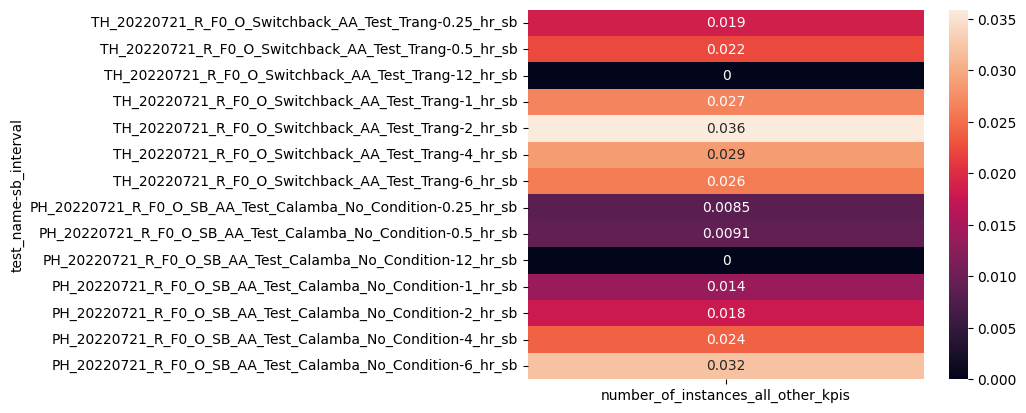

In [45]:
# Check the equal split of 'On'/'Off' instances **without** randomization
df_split_check_diff_sims_sorted = df_split_check_diff_sims.groupby(['test_name', 'sb_interval']).mean()
sns.heatmap(
    df_split_check_diff_sims_sorted.sort_values(by = 'test_name', axis = 0, ascending = False),
    annot = True
)


### Heatmap like the one shown above, but manual

<AxesSubplot:ylabel='test_name-sb_interval'>

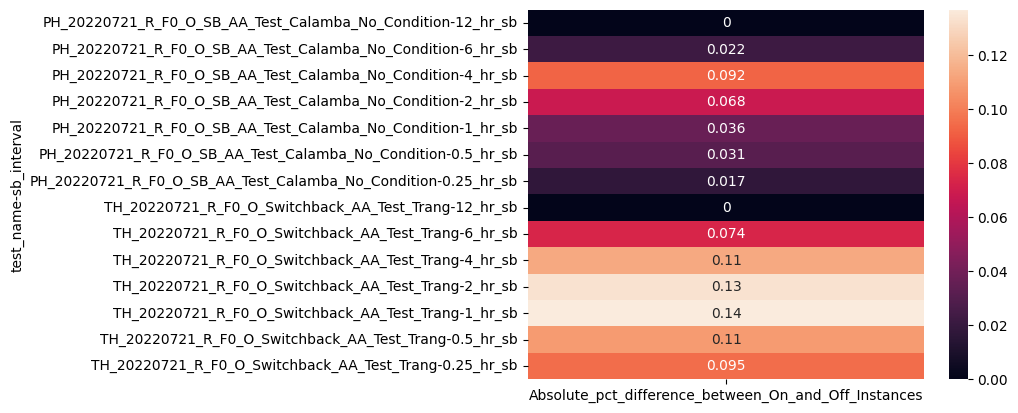

In [69]:
idx = pd.MultiIndex.from_product(
    [['PH_20220721_R_F0_O_SB_AA_Test_Calamba_No_Condition', 'TH_20220721_R_F0_O_Switchback_AA_Test_Trang'],
    ['12_hr_sb', '6_hr_sb', '4_hr_sb', '2_hr_sb', '1_hr_sb', '0.5_hr_sb', '0.25_hr_sb']],
    names = ['test_name', 'sb_interval']
)

col = ['Absolute_pct_difference_between_On_and_Off_Instances']

df_split_heatmap = pd.DataFrame(
    # Randomizing with ToD and DoW
    # data = {'Absolute_pct_difference_between_On_and_Off_Instances': [0, 0.03205, 0.024083, 0.017917, 0.013767, 0.0091, 0.00845, 0, 0.02605, 0.028633, 0.035883, 0.026683, 0.022267, 0.018617]},
    # Randomizing with ToD ONLY
    data = {'Absolute_pct_difference_between_On_and_Off_Instances': [0, 0.022, 0.09215, 0.068117, 0.036467, 0.031117, 0.01725, 0, 0.0737, 0.1135, 0.13325, 0.1369, 0.108867, 0.094917]},
    index = idx,
    columns = col
)

sns.heatmap(df_split_heatmap, annot = True)

### Step 13: Checking the propagation effect

In [22]:
hr_interval_date_func_random(test_start = dt.date(2022, 7, 21), test_length = (dt.date(2022, 8, 17) - dt.date(2022, 7, 21)).days + 1, sb_interval = 24)

,hr_interval,treatment_status_by_time,sim_run,order_created_date_local
0,"[0.0, 24.024)",On,1,2022-07-21
1,"[0.0, 24.024)",On,2,2022-07-22
2,"[0.0, 24.024)",Off,3,2022-07-23
3,"[0.0, 24.024)",On,4,2022-07-24
4,"[0.0, 24.024)",Off,5,2022-07-25
5,"[0.0, 24.024)",Off,6,2022-07-26
6,"[0.0, 24.024)",On,7,2022-07-27
7,"[0.0, 24.024)",Off,8,2022-07-28
8,"[0.0, 24.024)",Off,9,2022-07-29
9,"[0.0, 24.024)",Off,10,2022-07-30


#